# SVI로 피팅 후, 기대 pay off 계산(쿠폰지급비율도 반영) / 최종 ver.

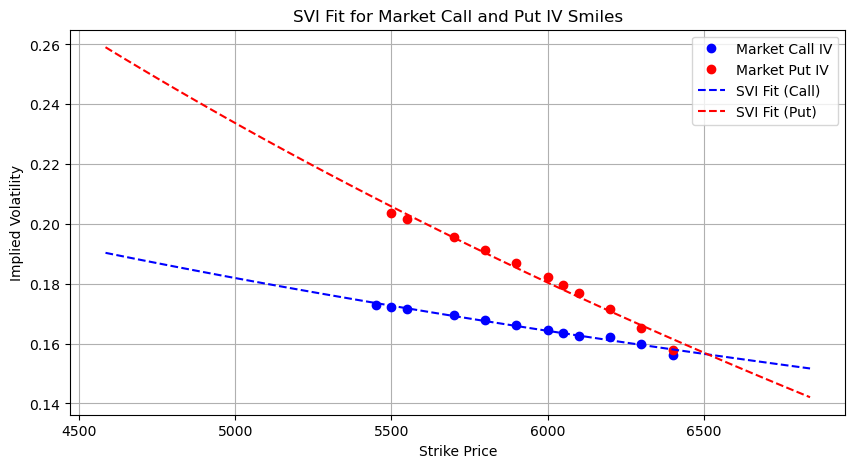

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 파일 불러오기
file_path = "data_spx.csv"


df = pd.read_csv(file_path)

# 데이터 확인
df.head()

# 숫자로 시작하는 Strike 값만 필터링 (잘못된 문자열 제거)
df_valid = df[df['Strike'].str.match(r'^\d')].copy()

# 쉼표 제거 및 변환
df_valid['Strike'] = df_valid['Strike'].str.replace(',', '').astype(float)
df_valid['IV'] = df_valid['IV'].str.replace('%', '').astype(float) / 100.0

# 기준 지수
S0 = 5600
df_valid['log_moneyness'] = np.log(df_valid['Strike'] / S0)

# Call과 Put 분리
df_call = df_valid[df_valid['Type'].str.lower() == 'call'].dropna()
df_put = df_valid[df_valid['Type'].str.lower() == 'put'].dropna()

import pandas as pd



# SVI 모델과 최적화 함수 다시 정의
from scipy.optimize import minimize

def svi_raw(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

def svi_loss(params, k_obs, iv_obs):
    a, b, rho, m, sigma = params
    iv_model = svi_raw(k_obs, a, b, rho, m, sigma)
    return np.sum((iv_model - iv_obs) ** 2)

def fit_svi(k_obs, iv_obs):
    init_params = [0.02, 0.1, 0.0, 0.0, 0.1]
    bounds = [(-1, 1), (1e-5, 1), (-0.999, 0.999), (-1, 1), (1e-5, 1)]
    result = minimize(svi_loss, init_params, args=(k_obs, iv_obs), bounds=bounds)
    return result.x

# SVI 피팅
params_call = fit_svi(df_call['log_moneyness'].values, df_call['IV'].values)
params_put = fit_svi(df_put['log_moneyness'].values, df_put['IV'].values)

# 예측 SVI IV
k_range = np.linspace(-0.2, 0.2, 100)
iv_svi_call = svi_raw(k_range, *params_call)
iv_svi_put = svi_raw(k_range, *params_put)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_call['Strike'], df_call['IV'], 'bo', label='Market Call IV')
plt.plot(df_put['Strike'], df_put['IV'], 'ro', label='Market Put IV')
plt.plot(np.exp(k_range) * S0, iv_svi_call, 'b--', label='SVI Fit (Call)')
plt.plot(np.exp(k_range) * S0, iv_svi_put, 'r--', label='SVI Fit (Put)')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('SVI Fit for Market Call and Put IV Smiles')
plt.grid(True)
plt.legend()
plt.show()


최종버전(쿠폰 비율 산출법 = 원금보장형으로)

# 목표 쿠폰률을 이용해 디지털 콜 Q 역산

실제 검증 시, r은 어떤 값으로 할지, S0는 어떤 값으로 할지, 날짜는 언제를 기준으로 삼을지, 목표 쿠폰율별 Q값의 변화도 확인하기

In [2]:
import numpy as np
from scipy.stats import norm

# Parameters
S0 = 5600
r = 0.038
T = 3
K_range = np.arange(0.97 * S0, 1.015 * S0, 20)   # 0.98 ~ 1.01 → 0.97 ~ 1.015
B_range = np.arange(0.88 * S0, 0.94 * S0, 20)    # 0.90 ~ 0.93 → 0.88 ~ 0.94

r_coupon_target = 0.03  # 목표 쿠폰율

# Digital Call Pricing (with Q)
def digital_call_short_price(S0, K, r, sigma, T, Q=1.0):
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    price = -Q * np.exp(-r * T) * norm.cdf(d2)
    delta = -Q * np.exp(-r * T) * norm.pdf(d2) / (sigma * np.sqrt(T) * S0)
    prob = norm.cdf(d2)
    return price, delta, prob

# Barrier Put Pricing
def barrier_put_short_price(S0, K, B, r, sigma, T, M=10000, N=126):
    dt = T / N
    payoffs = []
    for _ in range(M):
        S = [S0]
        for _ in range(N):
            z = np.random.normal()
            S.append(S[-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z))
        knocked_in = min(S) <= B
        payoff = max(K - S[-1], 0) if knocked_in else 0
        payoffs.append(-payoff)
    price = np.exp(-r * T) * np.mean(payoffs)

    # Delta (finite difference)
    delta_S = 0.01 * S0
    payoffs_up = []
    for _ in range(200):
        S_up = [S0 + delta_S]
        for _ in range(N):
            z = np.random.normal()
            S_up.append(S_up[-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z))
        knocked_in_up = min(S_up) <= B
        payoff_up = max(K - S_up[-1], 0) if knocked_in_up else 0
        payoffs_up.append(-payoff_up)
    price_up = np.exp(-r * T) * np.mean(payoffs_up)
    delta = -(price_up - price) / delta_S
    return price, delta

# SVI IV
def svi_iv(k, a, b, rho, m, sigma):
    return np.sqrt(a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + sigma ** 2)))

def make_svi_sigma_func(S0, a, b, rho, m, sigma):
    def sigma_func(K):
        k = np.log(K / S0)
        return svi_iv(k, a, b, rho, m, sigma)
    return sigma_func

# Coupon Rate 계산
def compute_coupon_rate(max_margin, S0, r, T):
    bond_cost = 1 - np.exp(-r * T)
    coupon_total = -(max_margin / S0) - bond_cost
    return coupon_total / T

# 목표 margin 계산
def required_margin(target_coupon_rate, S0, r, T):
    bond_cost = 1 - np.exp(-r * T)
    coupon_total = target_coupon_rate * T
    return -(coupon_total + bond_cost) * S0

# 최적화 (Q 없이 먼저 margin 구함)
def optimize_delta_neutral_pair(S0, r, T, sigma_func_call, sigma_func_put, K_range, B_range, M=10000, N=126, delta_tol=0.05):
    max_margin = -np.inf
    best_K, best_B = None, None
    best_prob = None
    for K in K_range:
        sigma_call = sigma_func_call(K)
        _, C_delta, prob = digital_call_short_price(S0, K, r, sigma_call, T, Q=1)
        for B in B_range:
            sigma_put = sigma_func_put(K)
            P_price, P_delta = barrier_put_short_price(S0, K, B, r, sigma_put, T, M, N)
            total_delta = C_delta + P_delta
            margin = -np.exp(-r * T) * prob + P_price  # Q = 1 가정
            if abs(total_delta) < delta_tol and margin > max_margin:
                max_margin = margin
                best_K, best_B = K, B
                best_prob = prob
    return best_K, best_B, max_margin, best_prob

# SVI 파라미터 설정
a_call, b_call, rho_call, m_call, sigma_call = 0.02, 0.2, -0.3, 0.0, 0.2
a_put, b_put, rho_put, m_put, sigma_put = 0.04, 0.3, -0.6, -0.1, 0.25

# Sigma 함수
sigma_func_call = make_svi_sigma_func(S0, a_call, b_call, rho_call, m_call, sigma_call)
sigma_func_put = make_svi_sigma_func(S0, a_put, b_put, rho_put, m_put, sigma_put)

# 최적화 실행
best_K, best_B, margin_with_Q1, prob = optimize_delta_neutral_pair(S0, r, T, sigma_func_call, sigma_func_put, K_range, B_range)

# 목표 마진
target_margin = required_margin(r_coupon_target, S0, r, T)

# Q 계산
Q_required = (target_margin - (margin_with_Q1 + np.exp(-r * T) * prob)) / prob

(best_K, best_B, r_coupon_target, Q_required)

final_margin = -Q_required * np.exp(-r * T) * prob + (margin_with_Q1 + np.exp(-r * T) * prob)


print(f"최적 행사가는 {best_K}입니다")
print(f"최적 베리어 가격은 {best_B}입니다")
print(f"목표 쿠폰율이 {r_coupon_target*100}%일 때, 적절 디지털 콜 Q값은 {-Q_required} 입니다")
print(f"Q값을 반영한 최종 기대 pay off는 {-final_margin/5600*100}%입니다")

최적 행사가는 5432.0입니다
최적 베리어 가격은 5048.0입니다
목표 쿠폰율이 3.0%일 때, 적절 디지털 콜 Q값은 559.6869189256961 입니다
Q값을 반영한 최종 기대 pay off는 9.42968597644066%입니다


### for 문 노가다

In [2]:
import numpy as np
from scipy.stats import norm

# Parameters
S0 = 5600
r = 0.038
T = 3
K_range = np.arange(0.97 * S0, 1.015 * S0, 20)   # 0.97 S0 ~ 1.015 S0
B_range = np.arange(0.88 * S0, 0.94 * S0, 20)    # 0.88 S0 ~ 0.94 S0

# Digital Call Pricing (with Q)
def digital_call_short_price(S0, K, r, sigma, T, Q=1.0):
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    price = -Q * np.exp(-r * T) * norm.cdf(d2)
    delta = -Q * np.exp(-r * T) * norm.pdf(d2) / (sigma * np.sqrt(T) * S0)
    prob = norm.cdf(d2)
    return price, delta, prob

# Barrier Put Pricing
def barrier_put_short_price(S0, K, B, r, sigma, T, M=10000, N=126):
    dt = T / N
    payoffs = []
    for _ in range(M):
        S = [S0]
        for _ in range(N):
            z = np.random.normal()
            S.append(S[-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z))
        knocked_in = min(S) <= B
        payoff = max(K - S[-1], 0) if knocked_in else 0
        payoffs.append(-payoff)
    price = np.exp(-r * T) * np.mean(payoffs)

    # Delta (finite difference)
    delta_S = 0.01 * S0
    payoffs_up = []
    for _ in range(200):
        S_up = [S0 + delta_S]
        for _ in range(N):
            z = np.random.normal()
            S_up.append(S_up[-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z))
        knocked_in_up = min(S_up) <= B
        payoff_up = max(K - S_up[-1], 0) if knocked_in_up else 0
        payoffs_up.append(-payoff_up)
    price_up = np.exp(-r * T) * np.mean(payoffs_up)
    delta = -(price_up - price) / delta_S
    return price, delta

# SVI IV
def svi_iv(k, a, b, rho, m, sigma):
    return np.sqrt(a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + sigma ** 2)))

def make_svi_sigma_func(S0, a, b, rho, m, sigma):
    def sigma_func(K):
        k = np.log(K / S0)
        return svi_iv(k, a, b, rho, m, sigma)
    return sigma_func

# Coupon Rate 계산
def compute_coupon_rate(max_margin, S0, r, T):
    bond_cost = 1 - np.exp(-r * T)
    coupon_total = -(max_margin / S0) - bond_cost
    return coupon_total / T

# 목표 margin 계산
def required_margin(target_coupon_rate, S0, r, T):
    bond_cost = 1 - np.exp(-r * T)
    coupon_total = target_coupon_rate * T
    return -(coupon_total + bond_cost) * S0

# 최적화 (Q 없이 먼저 margin 구함)
def optimize_delta_neutral_pair(S0, r, T, sigma_func_call, sigma_func_put, K_range, B_range, M=10000, N=126, delta_tol=0.05):
    max_margin = -np.inf
    best_K, best_B = None, None
    best_prob = None
    for K in K_range:
        sigma_call = sigma_func_call(K)
        _, C_delta, prob = digital_call_short_price(S0, K, r, sigma_call, T, Q=1)
        for B in B_range:
            sigma_put = sigma_func_put(K)
            P_price, P_delta = barrier_put_short_price(S0, K, B, r, sigma_put, T, M, N)
            total_delta = C_delta + P_delta
            margin = -np.exp(-r * T) * prob + P_price  # Q = 1 가정
            if abs(total_delta) < delta_tol and margin > max_margin:
                max_margin = margin
                best_K, best_B = K, B
                best_prob = prob
    return best_K, best_B, max_margin, best_prob

# SVI 파라미터 설정
a_call, b_call, rho_call, m_call, sigma_call = 0.02, 0.2, -0.3, 0.0, 0.2
a_put, b_put, rho_put, m_put, sigma_put = 0.04, 0.3, -0.6, -0.1, 0.25

# Sigma 함수
sigma_func_call = make_svi_sigma_func(S0, a_call, b_call, rho_call, m_call, sigma_call)
sigma_func_put = make_svi_sigma_func(S0, a_put, b_put, rho_put, m_put, sigma_put)

# 우선 Q=1 상태에서 최적 (K, B), 마진, 확률 계산
best_K, best_B, margin_with_Q1, prob = optimize_delta_neutral_pair(
    S0, r, T,
    sigma_func_call, sigma_func_put,
    K_range, B_range
)

# 쿠폰율 후보 범위 생성 (예: 0% ~ 10%, 0.001 간격)
coupon_candidates = np.arange(0.045, 0.055, 0.001)

best_coupon = None
best_coupon_margin = -np.inf

# 각 후보 r_coupon_target에 대하여
for coupon in coupon_candidates:
    target_margin = required_margin(coupon, S0, r, T)
    Q_required = (target_margin - (margin_with_Q1 + np.exp(-r * T) * prob)) / prob
    final_margin = -Q_required * np.exp(-r * T) * prob + (margin_with_Q1 + np.exp(-r * T) * prob)

    # 최적 쿠폰: final_margin >= 0이면서 쿠폰율이 최대인 경우
    if final_margin >= 0 and coupon > (best_coupon or 0):
        best_coupon = coupon
        best_coupon_margin = final_margin

# 결과 출력
if best_coupon is None:
    print("모든 후보 쿠폰에 대해 최종 기대 페이오프가 음수였습니다.")
else:
    # 최적 쿠폰과 그때의 Q_required 및 final_margin
    target_margin_opt = required_margin(best_coupon, S0, r, T)
    Q_required_opt = (target_margin_opt - (margin_with_Q1 + np.exp(-r * T) * prob)) / prob
    final_margin_opt = -Q_required_opt * np.exp(-r * T) * prob + (margin_with_Q1 + np.exp(-r * T) * prob)

    print(f"▶ 최적 쿠폰율 r_coupon_target = {best_coupon:.3f} (={best_coupon*100:.2f}%)")
    print(f"▶ 해당 쿠폰일 때 Q_required = {Q_required_opt:.6f}")
    print(f"▶ 해당 쿠폰일 때 최종 기대 pay off = {final_margin_opt/5600*100:.6f}%")
    print(f"▶ 최적 행사가는 {best_K}, 최적 베리어 가격은 {best_B} 입니다")

모든 후보 쿠폰에 대해 최종 기대 페이오프가 음수였습니다.
